****In this study, it is analyzed whether the headlines obtained from various sites are sarcastic or not.****
Naive Bayes is a simple "probabilistic classifiers" and based on Bayes theorem. It can be expressed as: 
\begin{equation*}
P(c/x)   = \frac{ P(x/c) * P(c)}{P(x)}
\end{equation*}


*  P(c) = Prior probabilty
*  P(x/c) = Likelihood
*  P(c/x) = Posterior probability
 
It is assumed that all the features have an equal effect on the outcome and features  has unrelated to the presence of any other feature.



In [1]:
import pandas as pd
import numpy as np
import re #regular expression
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import operator
import pylab as pl
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [2]:
#pre-precessing methods
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 

#install stopwords
stopwords = set(stopwords.words('english'))
stopwords.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

In [3]:
def calculate_prob(a):
    read_dict = {}
    for read in a:
        for r in read:
            if r in read_dict:
                val_old = read_dict[r]
                val_new = val_old + 1
                read_dict[r] = val_new
            else:
                read_dict[r] = 1
    return read_dict

In [4]:
#if we moved words have low frequecny, increase the accuracy 
def delete_low_frequency(a):
    b = a.copy()
    for read in a:
        if a[read] < 3:
            b.pop(read)
    return b


In [5]:
#For only test
def calculate_error_zero(test):
    probability_zero = 1
    smooth_zero = 1/(len(label_train_zero_class) + len(label_train)) #it is so important to use smooting factor..
    for keys in range(len(test)):
        probability_zero = probability_zero * prob_zero.get(test[keys], smooth_zero)
    return probability_zero * zero_prior_pb


def calculate_error_one(test):
    probability_one = 1
    smooth_one = 1/(len(label_train_one_class) + len(label_train)) 
    for keys in range(len(test)):
        probability_one = probability_one * prob_one.get(test[keys],smooth_one)
    return probability_one * one_prior_pb

In [6]:
def tokenize(message):
    message = message.lower()
    all_words = re.findall("[a-zA-z+]+", message)
   # print(all_words)
    all_words_alpha = [word.lower() for word in all_words if word.isalpha()]
   # print(all_words_alpha)
    all_words_lemmate = [ps.stem(lemmatizer.lemmatize(w)) for w in all_words_alpha]
   # print(all_words_lemmate)
    return all_words_lemmate

In [7]:
def punc_ques(df):   #we decide to use ? and ! they are meaningfull to sarcatism.. 
    punc = "?!"
    replace_with=[' '+i+' ' for i in punc]
    to_replace=[re.escape(i) for i in punc]
    df = pd.DataFrame(df).replace(to_replace,replace_with,regex=True)
    return df

In [8]:
def count_punc_ques(data):
    punc_count = 0
    ques_count = 0
    if type(data) == pd.core.frame.DataFrame: #for train data
        for i in data["headline"]:
            for j in i:
                if j == "?":
                    ques_count+=1
                elif j == "!":
                    punc_count+=1
    elif type(data) == str:             #for test data
        for j in data:
            if j == "?":
                ques_count+=1
            elif j == "!":
                punc_count+=1
        
    return punc_count,ques_count

In [9]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [10]:
df = df.drop(['article_link'], axis=1)

train_filenames = df[:20000]

label_train = train_filenames['is_sarcastic']

zero_class = train_filenames[label_train == 0]
one_class = train_filenames[label_train == 1]

zero_class = zero_class.sample(frac=1).reset_index(drop=True)
one_class = one_class.sample(frac=1).reset_index(drop=True)

label_train_zero_class = zero_class['is_sarcastic']
label_train_one_class = one_class['is_sarcastic']

numberofelement = label_train.count()
zero_prior_pb = (label_train[label_train == 0].count()) / numberofelement   #prior probab
one_prior_pb = (label_train[label_train == 1].count()) / numberofelement

print("Neutral Prior Prob : %s" %zero_prior_pb)
print("Sarcasm Prior Prob : %s"%one_prior_pb)

Neutral Prior Prob : 0.5603
Sarcasm Prior Prob : 0.4397


In [11]:
tokenized_zero_class = []
tokenized_one_class = []
a = []

one_class = punc_ques(one_class)   #for ? and !
zero_class = punc_ques(zero_class)  #for ? and !
one_punc, one_ques = count_punc_ques(one_class)
zero_punc, zero_ques = count_punc_ques(zero_class)

for i in range(label_train_zero_class.count()):
    tokenized_zero_class.append(tokenize(zero_class['headline'][i]))

for i in range(label_train_one_class.count()):
    tokenized_one_class.append(tokenize(one_class['headline'][i]))

tokenized_zero_class_prob = []
for doc in tokenized_zero_class:
    tokenized_zero_class_prob.append([i.lower() for i in doc if i.lower() not in stopwords])

tokenized_zero_class_prob_clean = delete_low_frequency(calculate_prob(tokenized_zero_class_prob))
tokenized_zero_class_prob_clean["!"] = zero_punc 
tokenized_zero_class_prob_clean["?"] = zero_ques 

tokenized_one_class_prob = []
for doc in tokenized_one_class:
    tokenized_one_class_prob.append([i.lower() for i in doc if i.lower() not in stopwords])

tokenized_one_class_prob_clean = delete_low_frequency(calculate_prob(tokenized_one_class_prob))
tokenized_one_class_prob_clean["!"] = one_punc 
tokenized_one_class_prob_clean["?"] = one_ques 

prob_zero = {}
for read in tokenized_zero_class_prob_clean.keys():
    prob_zero[read] = tokenized_zero_class_prob_clean[read] / sum(tokenized_zero_class_prob_clean.values())

prob_one = {}
for read in tokenized_one_class_prob_clean.keys():
    prob_one[read] = tokenized_one_class_prob_clean[read] / sum(tokenized_one_class_prob_clean.values())

In [12]:
#example of probabilty dictionary
for e in range(5):
    print(([x for x in prob_zero.keys()][e], [x for x in prob_zero.values()][e]))

('jack', 0.00012899342133551188)
('open', 0.001132275587278382)
('struggl', 0.00034398245689469835)
('depress', 0.00030098464978286105)
('thi', 0.007338292413753565)


* > ****Test****

In [13]:
test_filenames = df[20000:]
test_data = test_filenames.sample(frac=1).reset_index(drop=True)
label_test = test_data['is_sarcastic']
TP = TN = FP = FN = 0
precision = recall = f1_score = accurancy = specificity = 0
sample_right_zero = []
sample_wrong_zero = []
sample_right_one = []
sample_wrong_one = []

test_data = punc_ques(test_data)  #for ? and !

for i in range(label_test.count()):
    test_sample = test_data['headline'][i]
    test_punc, test_ques = count_punc_ques(test_sample)
    tokenized_test = tokenize(test_sample)
    tokenized_test_prob = []
    tokenized_test_prob = [i.lower() for i in tokenized_test if i.lower() not in stopwords]
    if test_punc != 0 :
        tokenized_test_prob.append("!")
    if test_ques != 0:
        tokenized_test_prob.append("?")
    calculated_zero_prob = calculate_error_zero(tokenized_test_prob)
    calculated_one_prob = calculate_error_one(tokenized_test_prob)
    if calculated_zero_prob > calculated_one_prob:
        if label_test[i] == 1:
            FN += 1
            sample_wrong_one.append(test_data['headline'][i])
        elif label_test[i] == 0:
            TN += 1
            sample_right_zero.append(test_data['headline'][i])
    else:
        if label_test[i] == 1:
            TP += 1
            sample_right_one.append(test_data['headline'][i])
        elif label_test[i] == 0:
            FP += 1
            sample_wrong_zero.append(test_data['headline'][i])

In [14]:
accurancy = (TN+TP) / label_test.count()
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2*((precision*recall)/(precision+recall))

print("Accuracy is :", accurancy)
print("Precision is :", precision)
print("Recall is :", recall)
print("Specificity is :", specificity)
print("F1-score is :", f1_score)

Accuracy is : 0.7881949619913549
Precision is : 0.7560230743128605
Recall is : 0.7604095563139932
Specificity is : 0.8097380259327864
F1-score is : 0.758209971073677


In [15]:
print("Right Samples of Neutral Headlines are :")
for i in range (5) :
    print(sample_right_zero[i])


Right Samples of Neutral Headlines are :
alec baldwin ridicules donald trump over his disgusting comments about women on 'snl'
congresswoman says former congressman tried to force himself on her in elevator
erick erickson, noted sexist, slams donald trump for being sexist
officials raid home of activist behind planned parenthood 'sting' videos
why is the naacp in bed with donald sterling ? 


In [16]:
print("Wrong Samples of Neutral Headlines are :")
for i in range (5) :
    print(sample_wrong_zero[i])

Wrong Samples of Neutral Headlines are :
alfonso ribeiro may be forced to leave 'dwts'
this senate candidate explains how god-awful and life consuming fundraising is
we tested the new 'tearless' onions to see if they really work
code words for spinster throughout history
infuriating video shows meek mill making homeless man do pushups for $20


In [17]:
print("Right Samples of Sarcastic Headlines are :")
for i in range (5) :
    print(sample_right_one[i])

Right Samples of Sarcastic Headlines are :
man returns to work after vacation with fresh, reenergized hatred for job
garden too much for grandma this summer
aztec extremists cut out visiting pope's heart
third-grader clearly biting off more than he can chew at elementary school book fair
free-range chicken makes it to bolivia


In [18]:
print("Wrong Samples of Sarcastic Headlines are :")
for i in range (5) :
    print(sample_wrong_one[i])

Wrong Samples of Sarcastic Headlines are :
black man in support of confederate flag triples his media appearance rates
trump boys announce they will not hesitate to egg russia if provoked
50-year-old prince licks aarp representative's face
nelson mandela admits thoughts, prayers of millions played no part in recovery
cnn releases photos of 3 obese mexican women suspected in boston bombing


In [19]:
one_most  = max(tokenized_one_class_prob_clean.items(), key=operator.itemgetter(1))[0]
zero_most = max(tokenized_zero_class_prob_clean.items(), key=operator.itemgetter(1))[0]
print("The most accurated word for sarcastic headlines is: ",one_most,
      " and it repeats ",tokenized_one_class_prob_clean[one_most], "times.")


The most accurated word for sarcastic headlines is:  man  and it repeats  862 times.


In [20]:
print("The most accurated word for neutral headlines is: ",zero_most,
      " and it repeats ",tokenized_zero_class_prob_clean[zero_most], "times.")

The most accurated word for neutral headlines is:  trump  and it repeats  1083 times.


Text(0.5,1,'Not Sarcasm - Words')

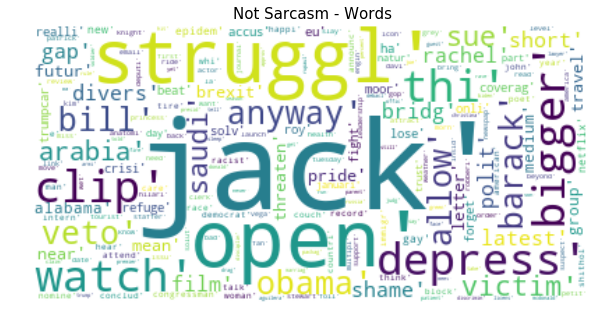

In [21]:
pl.figure(figsize =(10,10))
not_sarcastic = str(tokenized_zero_class_prob_clean)
wordCloud = WordCloud(background_color="white").generate(not_sarcastic)
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.title('Not Sarcasm - Words', fontsize=15)